<a href="https://colab.research.google.com/github/DiNOV-Tokyo/yolov5/blob/main/3_8_PSPNet_inference.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 3.8 推論の実施

- 本ファイルでは、学習させたPSPNetでセマンティックセグメンテーションを行います。


# 学習目標


1.	セマンティックセグメンテーションの推論を実装できるようになる


# 事前準備

- 学習させた重みパラメータ「pspnet50_30.pth」をフォルダ「weights」に用意する。

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/My\ Drive/Colab\ Notebooks
#%mkdir yolo_train
%cd yolo_train

/content/drive/My Drive/Colab Notebooks
/content/drive/My Drive/Colab Notebooks/yolo_train


In [3]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import torch

# ファイルパスリストを用意

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, models, transforms

import numpy as np
from tqdm import tqdm
from PIL import Image

print('Setup complete. Using torch %s %s' % (torch.__version__, torch.cuda.get_device_properties(0) if torch.cuda.is_available() else 'CPU'))

Setup complete. Using torch 1.9.0+cu111 CPU


In [15]:
# 第3章セマンティックセグメンテーションのデータオーギュメンテーション
# 注意　アノテーション画像はカラーパレット形式（インデックスカラー画像）となっている。

# パッケージのimport
import torch
from torchvision import transforms
from PIL import Image, ImageOps, ImageFilter
import numpy as np


class Compose(object):
    """引数transformに格納された変形を順番に実行するクラス
       対象画像とアノテーション画像を同時に変換させます。 
    """

    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, img, anno_class_img):
        for t in self.transforms:
            img, anno_class_img = t(img, anno_class_img)
        return img, anno_class_img


class Scale(object):
    def __init__(self, scale):
        self.scale = scale

    def __call__(self, img, anno_class_img):

        width = img.size[0]  # img.size=[幅][高さ]
        height = img.size[1]  # img.size=[幅][高さ]

        # 拡大倍率をランダムに設定
        scale = np.random.uniform(self.scale[0], self.scale[1])

        scaled_w = int(width * scale)  # img.size=[幅][高さ]
        scaled_h = int(height * scale)  # img.size=[幅][高さ]

        # 画像のリサイズ
        img = img.resize((scaled_w, scaled_h), Image.BICUBIC)

        # アノテーションのリサイズ
        anno_class_img = anno_class_img.resize(
            (scaled_w, scaled_h), Image.NEAREST)

        # 画像を元の大きさに
        # 切り出し位置を求める
        if scale > 1.0:
            left = scaled_w - width
            left = int(np.random.uniform(0, left))

            top = scaled_h-height
            top = int(np.random.uniform(0, top))

            img = img.crop((left, top, left+width, top+height))
            anno_class_img = anno_class_img.crop(
                (left, top, left+width, top+height))

        else:
            # input_sizeよりも短い辺はpaddingする
            p_palette = anno_class_img.copy().getpalette()

            img_original = img.copy()
            anno_class_img_original = anno_class_img.copy()

            pad_width = width-scaled_w
            pad_width_left = int(np.random.uniform(0, pad_width))

            pad_height = height-scaled_h
            pad_height_top = int(np.random.uniform(0, pad_height))

            img = Image.new(img.mode, (width, height), (0, 0, 0))
            img.paste(img_original, (pad_width_left, pad_height_top))

            anno_class_img = Image.new(
                anno_class_img.mode, (width, height), (0))
            anno_class_img.paste(anno_class_img_original,
                                 (pad_width_left, pad_height_top))
            anno_class_img.putpalette(p_palette)

        return img, anno_class_img


class RandomRotation(object):
    def __init__(self, angle):
        self.angle = angle

    def __call__(self, img, anno_class_img):

        # 回転角度を決める
        rotate_angle = (np.random.uniform(self.angle[0], self.angle[1]))

        # 回転
        img = img.rotate(rotate_angle, Image.BILINEAR)
        anno_class_img = anno_class_img.rotate(rotate_angle, Image.NEAREST)

        return img, anno_class_img


class RandomMirror(object):
    """50%の確率で左右反転させるクラス"""

    def __call__(self, img, anno_class_img):
        if np.random.randint(2):
            img = ImageOps.mirror(img)
            anno_class_img = ImageOps.mirror(anno_class_img)
        return img, anno_class_img


class Resize(object):
    """引数input_sizeに大きさを変形するクラス"""

    def __init__(self, input_size):
        self.input_size = input_size

    def __call__(self, img, anno_class_img):

        # width = img.size[0]  # img.size=[幅][高さ]
        # height = img.size[1]  # img.size=[幅][高さ]

        img = img.resize((self.input_size, self.input_size),
                         Image.BICUBIC)
        anno_class_img = anno_class_img.resize(
            (self.input_size, self.input_size), Image.NEAREST)

        return img, anno_class_img


class Normalize_Tensor(object):
    def __init__(self, color_mean, color_std):
        self.color_mean = color_mean
        self.color_std = color_std

    def __call__(self, img, anno_class_img):

        # PIL画像をTensorに。大きさは最大1に規格化される
        img = transforms.functional.to_tensor(img)

        # 色情報の標準化
        img = transforms.functional.normalize(
            img, self.color_mean, self.color_std)

        # アノテーション画像をNumpyに変換
        anno_class_img = np.array(anno_class_img)  # [高さ][幅]

        # 'ambigious'には255が格納されているので、0の背景にしておく
        index = np.where(anno_class_img == 255)
        anno_class_img[index] = 0

        # アノテーション画像をTensorに
        anno_class_img = torch.from_numpy(anno_class_img)

        return img, anno_class_img


In [16]:
# パッケージのimport
import os.path as osp
from PIL import Image
import torch.utils.data as data

#from utils.data_augumentation import Compose, Scale, RandomRotation, RandomMirror, Resize, Normalize_Tensor


def make_datapath_list(rootpath):
    """
    学習、検証の画像データとアノテーションデータへのファイルパスリストを作成する。

    Parameters
    ----------
    rootpath : str
        データフォルダへのパス

    Returns
    -------
    ret : train_img_list, train_anno_list, val_img_list, val_anno_list
        データへのパスを格納したリスト
    """

    # 画像ファイルとアノテーションファイルへのパスのテンプレートを作成
    imgpath_template = osp.join(rootpath, 'JPEGImages', '%s.jpg')
    annopath_template = osp.join(rootpath, 'SegmentationClass', '%s.png')

    # 訓練と検証、それぞれのファイルのID（ファイル名）を取得する
    train_id_names = osp.join(rootpath + 'ImageSets/Segmentation/train.txt')
    val_id_names = osp.join(rootpath + 'ImageSets/Segmentation/val.txt')

    # 訓練データの画像ファイルとアノテーションファイルへのパスリストを作成
    train_img_list = list()
    train_anno_list = list()

    for line in open(train_id_names):
        file_id = line.strip()  # 空白スペースと改行を除去
        img_path = (imgpath_template % file_id)  # 画像のパス
        anno_path = (annopath_template % file_id)  # アノテーションのパス
        train_img_list.append(img_path)
        train_anno_list.append(anno_path)

    # 検証データの画像ファイルとアノテーションファイルへのパスリストを作成
    val_img_list = list()
    val_anno_list = list()

    for line in open(val_id_names):
        file_id = line.strip()  # 空白スペースと改行を除去
        img_path = (imgpath_template % file_id)  # 画像のパス
        anno_path = (annopath_template % file_id)  # アノテーションのパス
        val_img_list.append(img_path)
        val_anno_list.append(anno_path)

    return train_img_list, train_anno_list, val_img_list, val_anno_list


class DataTransform():
    """
    画像とアノテーションの前処理クラス。訓練時と検証時で異なる動作をする。
    画像のサイズをinput_size x input_sizeにする。
    訓練時はデータオーギュメンテーションする。


    Attributes
    ----------
    input_size : int
        リサイズ先の画像の大きさ。
    color_mean : (R, G, B)
        各色チャネルの平均値。
    color_std : (R, G, B)
        各色チャネルの標準偏差。
    """

    def __init__(self, input_size, color_mean, color_std):
        self.data_transform = {
            'train': Compose([
                Scale(scale=[0.5, 1.5]),  # 画像の拡大
                RandomRotation(angle=[-10, 10]),  # 回転
                RandomMirror(),  # ランダムミラー
                Resize(input_size),  # リサイズ(input_size)
                Normalize_Tensor(color_mean, color_std)  # 色情報の標準化とテンソル化
            ]),
            'val': Compose([
                Resize(input_size),  # リサイズ(input_size)
                Normalize_Tensor(color_mean, color_std)  # 色情報の標準化とテンソル化
            ])
        }

    def __call__(self, phase, img, anno_class_img):
        """
        Parameters
        ----------
        phase : 'train' or 'val'
            前処理のモードを指定。
        """
        return self.data_transform[phase](img, anno_class_img)


class VOCDataset(data.Dataset):
    """
    VOC2012のDatasetを作成するクラス。PyTorchのDatasetクラスを継承。

    Attributes
    ----------
    img_list : リスト
        画像のパスを格納したリスト
    anno_list : リスト
        アノテーションへのパスを格納したリスト
    phase : 'train' or 'test'
        学習か訓練かを設定する。
    transform : object
        前処理クラスのインスタンス
    """

    def __init__(self, img_list, anno_list, phase, transform):
        self.img_list = img_list
        self.anno_list = anno_list
        self.phase = phase
        self.transform = transform

    def __len__(self):
        '''画像の枚数を返す'''
        return len(self.img_list)

    def __getitem__(self, index):
        '''
        前処理をした画像のTensor形式のデータとアノテーションを取得
        '''
        img, anno_class_img = self.pull_item(index)
        return img, anno_class_img

    def pull_item(self, index):
        '''画像のTensor形式のデータ、アノテーションを取得する'''

        # 1. 画像読み込み
        image_file_path = self.img_list[index]
        img = Image.open(image_file_path)   # [高さ][幅][色RGB]

        # 2. アノテーション画像読み込み
        anno_file_path = self.anno_list[index]
        anno_class_img = Image.open(anno_file_path)   # [高さ][幅]

        # 3. 前処理を実施
        img, anno_class_img = self.transform(self.phase, img, anno_class_img)

        return img, anno_class_img


In [17]:
#from utils.dataloader import make_datapath_list, DataTransform


# ファイルパスリスト作成
rootpath = "./pspnet_data/VOCdevkit/VOC2012/"
train_img_list, train_anno_list, val_img_list, val_anno_list = make_datapath_list(
    rootpath=rootpath)

# 後ほどアノテーション画像のみを使用する


In [11]:
!pwd

/content/drive/My Drive/Colab Notebooks/yolo_train


# ネットワークを用意

In [19]:
# パッケージのimport
import torch
import torch.nn as nn
import torch.nn.functional as F


class PSPNet(nn.Module):
    def __init__(self, n_classes):
        super(PSPNet, self).__init__()

        # パラメータ設定
        block_config = [3, 4, 6, 3]  # resnet50
        img_size = 475
        img_size_8 = 60  # img_sizeの1/8に

        # 4つのモジュールを構成するサブネットワークの用意
        self.feature_conv = FeatureMap_convolution()
        self.feature_res_1 = ResidualBlockPSP(
            n_blocks=block_config[0], in_channels=128, mid_channels=64, out_channels=256, stride=1, dilation=1)
        self.feature_res_2 = ResidualBlockPSP(
            n_blocks=block_config[1], in_channels=256, mid_channels=128, out_channels=512, stride=2, dilation=1)
        self.feature_dilated_res_1 = ResidualBlockPSP(
            n_blocks=block_config[2], in_channels=512, mid_channels=256, out_channels=1024, stride=1, dilation=2)
        self.feature_dilated_res_2 = ResidualBlockPSP(
            n_blocks=block_config[3], in_channels=1024, mid_channels=512, out_channels=2048, stride=1, dilation=4)

        self.pyramid_pooling = PyramidPooling(in_channels=2048, pool_sizes=[
            6, 3, 2, 1], height=img_size_8, width=img_size_8)

        self.decode_feature = DecodePSPFeature(
            height=img_size, width=img_size, n_classes=n_classes)

        self.aux = AuxiliaryPSPlayers(
            in_channels=1024, height=img_size, width=img_size, n_classes=n_classes)

    def forward(self, x):
        x = self.feature_conv(x)
        x = self.feature_res_1(x)
        x = self.feature_res_2(x)
        x = self.feature_dilated_res_1(x)

        output_aux = self.aux(x)  # Featureモジュールの途中をAuxモジュールへ

        x = self.feature_dilated_res_2(x)

        x = self.pyramid_pooling(x)
        output = self.decode_feature(x)

        return (output, output_aux)


class conv2DBatchNormRelu(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding, dilation, bias):
        super(conv2DBatchNormRelu, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels,
                              kernel_size, stride, padding, dilation, bias=bias)
        self.batchnorm = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        # inplase設定で入力を保存せずに出力を計算し、メモリ削減する

    def forward(self, x):
        x = self.conv(x)
        x = self.batchnorm(x)
        outputs = self.relu(x)

        return outputs


class FeatureMap_convolution(nn.Module):
    def __init__(self):
        '''構成するネットワークを用意'''
        super(FeatureMap_convolution, self).__init__()

        # 畳み込み層1
        in_channels, out_channels, kernel_size, stride, padding, dilation, bias = 3, 64, 3, 2, 1, 1, False
        self.cbnr_1 = conv2DBatchNormRelu(
            in_channels, out_channels, kernel_size, stride, padding, dilation, bias)

        # 畳み込み層2
        in_channels, out_channels, kernel_size, stride, padding, dilation, bias = 64, 64, 3, 1, 1, 1, False
        self.cbnr_2 = conv2DBatchNormRelu(
            in_channels, out_channels, kernel_size, stride, padding, dilation, bias)

        # 畳み込み層3
        in_channels, out_channels, kernel_size, stride, padding, dilation, bias = 64, 128, 3, 1, 1, 1, False
        self.cbnr_3 = conv2DBatchNormRelu(
            in_channels, out_channels, kernel_size, stride, padding, dilation, bias)

        # MaxPooling層
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

    def forward(self, x):
        x = self.cbnr_1(x)
        x = self.cbnr_2(x)
        x = self.cbnr_3(x)
        outputs = self.maxpool(x)
        return outputs


class ResidualBlockPSP(nn.Sequential):
    def __init__(self, n_blocks, in_channels, mid_channels, out_channels, stride, dilation):
        super(ResidualBlockPSP, self).__init__()

        # bottleNeckPSPの用意
        self.add_module(
            "block1",
            bottleNeckPSP(in_channels, mid_channels,
                          out_channels, stride, dilation)
        )

        # bottleNeckIdentifyPSPの繰り返しの用意
        for i in range(n_blocks - 1):
            self.add_module(
                "block" + str(i+2),
                bottleNeckIdentifyPSP(
                    out_channels, mid_channels, stride, dilation)
            )


class conv2DBatchNorm(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding, dilation, bias):
        super(conv2DBatchNorm, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels,
                              kernel_size, stride, padding, dilation, bias=bias)
        self.batchnorm = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        x = self.conv(x)
        outputs = self.batchnorm(x)

        return outputs


class bottleNeckPSP(nn.Module):
    def __init__(self, in_channels, mid_channels, out_channels, stride, dilation):
        super(bottleNeckPSP, self).__init__()

        self.cbr_1 = conv2DBatchNormRelu(
            in_channels, mid_channels, kernel_size=1, stride=1, padding=0, dilation=1, bias=False)
        self.cbr_2 = conv2DBatchNormRelu(
            mid_channels, mid_channels, kernel_size=3, stride=stride, padding=dilation, dilation=dilation, bias=False)
        self.cb_3 = conv2DBatchNorm(
            mid_channels, out_channels, kernel_size=1, stride=1, padding=0, dilation=1, bias=False)

        # スキップ結合
        self.cb_residual = conv2DBatchNorm(
            in_channels, out_channels, kernel_size=1, stride=stride, padding=0, dilation=1, bias=False)

        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        conv = self.cb_3(self.cbr_2(self.cbr_1(x)))
        residual = self.cb_residual(x)
        return self.relu(conv + residual)


class bottleNeckIdentifyPSP(nn.Module):
    def __init__(self, in_channels, mid_channels, stride, dilation):
        super(bottleNeckIdentifyPSP, self).__init__()

        self.cbr_1 = conv2DBatchNormRelu(
            in_channels, mid_channels, kernel_size=1, stride=1, padding=0, dilation=1, bias=False)
        self.cbr_2 = conv2DBatchNormRelu(
            mid_channels, mid_channels, kernel_size=3, stride=1, padding=dilation, dilation=dilation, bias=False)
        self.cb_3 = conv2DBatchNorm(
            mid_channels, in_channels, kernel_size=1, stride=1, padding=0, dilation=1, bias=False)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        conv = self.cb_3(self.cbr_2(self.cbr_1(x)))
        residual = x
        return self.relu(conv + residual)


class PyramidPooling(nn.Module):
    def __init__(self, in_channels, pool_sizes, height, width):
        super(PyramidPooling, self).__init__()

        # forwardで使用する画像サイズ
        self.height = height
        self.width = width

        # 各畳み込み層の出力チャネル数
        out_channels = int(in_channels / len(pool_sizes))

        # 各畳み込み層を作成
        # この実装方法は愚直すぎてfor文で書きたいところですが、分かりやすさを優先しています
        # pool_sizes: [6, 3, 2, 1]
        self.avpool_1 = nn.AdaptiveAvgPool2d(output_size=pool_sizes[0])
        self.cbr_1 = conv2DBatchNormRelu(
            in_channels, out_channels, kernel_size=1, stride=1, padding=0, dilation=1, bias=False)

        self.avpool_2 = nn.AdaptiveAvgPool2d(output_size=pool_sizes[1])
        self.cbr_2 = conv2DBatchNormRelu(
            in_channels, out_channels, kernel_size=1, stride=1, padding=0, dilation=1, bias=False)

        self.avpool_3 = nn.AdaptiveAvgPool2d(output_size=pool_sizes[2])
        self.cbr_3 = conv2DBatchNormRelu(
            in_channels, out_channels, kernel_size=1, stride=1, padding=0, dilation=1, bias=False)

        self.avpool_4 = nn.AdaptiveAvgPool2d(output_size=pool_sizes[3])
        self.cbr_4 = conv2DBatchNormRelu(
            in_channels, out_channels, kernel_size=1, stride=1, padding=0, dilation=1, bias=False)

    def forward(self, x):

        out1 = self.cbr_1(self.avpool_1(x))
        out1 = F.interpolate(out1, size=(
            self.height, self.width), mode="bilinear", align_corners=True)

        out2 = self.cbr_2(self.avpool_2(x))
        out2 = F.interpolate(out2, size=(
            self.height, self.width), mode="bilinear", align_corners=True)

        out3 = self.cbr_3(self.avpool_3(x))
        out3 = F.interpolate(out3, size=(
            self.height, self.width), mode="bilinear", align_corners=True)

        out4 = self.cbr_4(self.avpool_4(x))
        out4 = F.interpolate(out4, size=(
            self.height, self.width), mode="bilinear", align_corners=True)

        # 最終的に結合させる、dim=1でチャネル数の次元で結合
        output = torch.cat([x, out1, out2, out3, out4], dim=1)

        return output


class DecodePSPFeature(nn.Module):
    def __init__(self, height, width, n_classes):
        super(DecodePSPFeature, self).__init__()

        # forwardで使用する画像サイズ
        self.height = height
        self.width = width

        self.cbr = conv2DBatchNormRelu(
            in_channels=4096, out_channels=512, kernel_size=3, stride=1, padding=1, dilation=1, bias=False)
        self.dropout = nn.Dropout2d(p=0.1)
        self.classification = nn.Conv2d(
            in_channels=512, out_channels=n_classes, kernel_size=1, stride=1, padding=0)

    def forward(self, x):
        x = self.cbr(x)
        x = self.dropout(x)
        x = self.classification(x)
        output = F.interpolate(
            x, size=(self.height, self.width), mode="bilinear", align_corners=True)

        return output


class AuxiliaryPSPlayers(nn.Module):
    def __init__(self, in_channels, height, width, n_classes):
        super(AuxiliaryPSPlayers, self).__init__()

        # forwardで使用する画像サイズ
        self.height = height
        self.width = width

        self.cbr = conv2DBatchNormRelu(
            in_channels=in_channels, out_channels=256, kernel_size=3, stride=1, padding=1, dilation=1, bias=False)
        self.dropout = nn.Dropout2d(p=0.1)
        self.classification = nn.Conv2d(
            in_channels=256, out_channels=n_classes, kernel_size=1, stride=1, padding=0)

    def forward(self, x):
        x = self.cbr(x)
        x = self.dropout(x)
        x = self.classification(x)
        output = F.interpolate(
            x, size=(self.height, self.width), mode="bilinear", align_corners=True)

        return output


In [20]:
#from utils.pspnet import PSPNet

net = PSPNet(n_classes=21)

# 学習済みパラメータをロード
state_dict = torch.load("./pspnet_weights/pspnet50_30.pth",
                        map_location={'cuda:0': 'cpu'})
net.load_state_dict(state_dict)

print('ネットワーク設定完了：学習済みの重みをロードしました')


ネットワーク設定完了：学習済みの重みをロードしました


# 推論実行

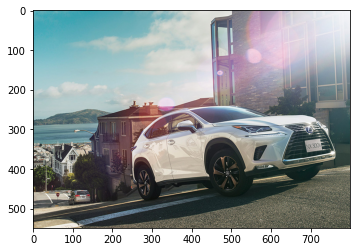

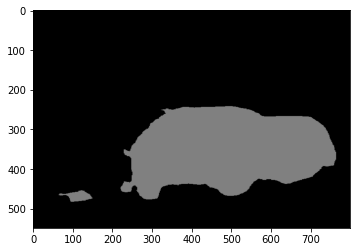

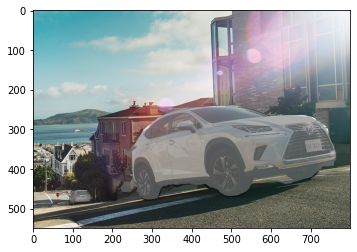

In [28]:
# 1. 元画像の表示
#image_file_path = "./pspnet_data/cowboy-g0996b768f_1920.jpg"
#image_file_path = "./pspnet_data/1515704.jpg"
#image_file_path = "./pspnet_data/1515708.jpg"
#image_file_path = "./pspnet_data/mainbnr08.jpg"
#image_file_path = "./pspnet_data/mirai210819-pic01-thumb-720xauto-265661.jpg"
#image_file_path = "./pspnet_data/P1J03646s-600x305.jpg"
image_file_path = "./pspnet_data/mainimg_c0006_01.jpg"

img = Image.open(image_file_path)   # [高さ][幅][色RGB]
img_width, img_height = img.size
plt.imshow(img)
plt.show()

# 2. 前処理クラスの作成
color_mean = (0.485, 0.456, 0.406)
color_std = (0.229, 0.224, 0.225)
transform = DataTransform(
    input_size=475, color_mean=color_mean, color_std=color_std)

# 3. 前処理
# 適当なアノテーション画像を用意し、さらにカラーパレットの情報を抜き出す
anno_file_path = val_anno_list[0]
anno_class_img = Image.open(anno_file_path)   # [高さ][幅]
p_palette = anno_class_img.getpalette()
phase = "val"
img, anno_class_img = transform(phase, img, anno_class_img)


# 4. PSPNetで推論する
net.eval()
x = img.unsqueeze(0)  # ミニバッチ化：torch.Size([1, 3, 475, 475])
outputs = net(x)
y = outputs[0]  # AuxLoss側は無視 yのサイズはtorch.Size([1, 21, 475, 475])


# 5. PSPNetの出力から最大クラスを求め、カラーパレット形式にし、画像サイズを元に戻す
y = y[0].detach().numpy()  # y：torch.Size([1, 21, 475, 475])
y = np.argmax(y, axis=0)
anno_class_img = Image.fromarray(np.uint8(y), mode="P")
anno_class_img = anno_class_img.resize((img_width, img_height), Image.NEAREST)
anno_class_img.putpalette(p_palette)
plt.imshow(anno_class_img)
plt.show()


# 6. 画像を透過させて重ねる
trans_img = Image.new('RGBA', anno_class_img.size, (0, 0, 0, 0))
anno_class_img = anno_class_img.convert('RGBA')  # カラーパレット形式をRGBAに変換

for x in range(img_width):
    for y in range(img_height):
        # 推論結果画像のピクセルデータを取得
        pixel = anno_class_img.getpixel((x, y))
        r, g, b, a = pixel

        # (0, 0, 0)の背景ならそのままにして透過させる
        if pixel[0] == 0 and pixel[1] == 0 and pixel[2] == 0:
            continue
        else:
            # それ以外の色は用意した画像にピクセルを書き込む
            trans_img.putpixel((x, y), (r, g, b, 150))
            # 150は透過度の大きさを指定している

img = Image.open(image_file_path)   # [高さ][幅][色RGB]
result = Image.alpha_composite(img.convert('RGBA'), trans_img)
plt.imshow(result)
plt.show()


以上